#Authors
Junyu Li: 260957495\
Ruohan Wang: 260911138

In [1]:
import numpy as np
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
from scipy.stats import sem 
import random
np.random.seed(0)
import math

In [2]:
lamda = 0.1
q_star = [0.5,0.5-lamda,0.5-2*lamda]
p = q_star

#Q1

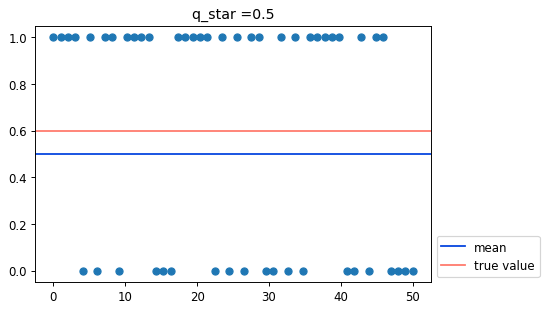

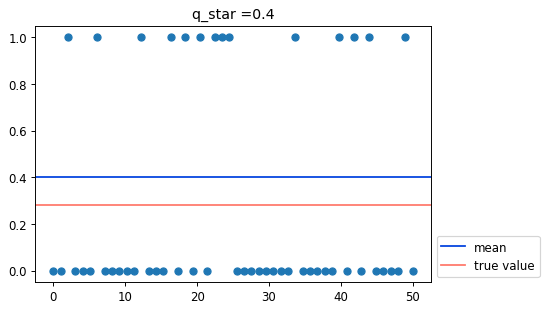

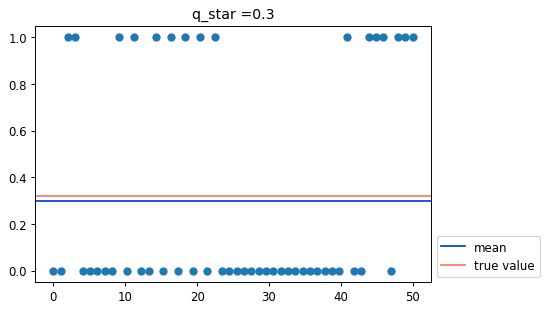

In [3]:
x = np.linspace(0, 50, 50)
plt.rcParams["figure.dpi"] = 85
num_samples = 50
samples = [np.random.binomial(1,q_star[0],num_samples),
           np.random.binomial(1,q_star[1],num_samples),
           np.random.binomial(1,q_star[2],num_samples)]
for i in range(len(q_star)):
  plt.plot(x, samples[i], 'o')
  plt.axhline(y = q_star[i], linestyle='-', color='#0343DF', label="mean")
  plt.axhline(y = np.mean(samples[i]), linestyle='-', color='#FF796C', label="true value")
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.1))
  plt.title('q_star =' + str(q_star[i]))
  plt.show()


# Model

In [102]:
class MAB:
    def __init__(self, bandit_probs, run_steps = None, c=None):
      self.bandit_probs = bandit_probs
      self.bandit_arms = len(self.bandit_probs)
      self.selection_rec = np.zeros(self.bandit_arms)
      self.successes = np.zeros(self.bandit_arms)
      self.run_steps = run_steps
      self.c = c

    def sample(self, action_idx):
      return np.random.binomial(1, self.bandit_probs[action_idx])

    def update(self, alpha, R, Q, step):
      Q[step] = Q[step-1] + alpha*(R[step-1]-Q[step-1])
      return Q

    def updateAvg(self, R, Q, step):
      Q[step] = Q[step-1] + (R[step-1]-Q[step-1])/(step)
      return Q

    def ucb(self, R, Q, alpha = None):
      ucb_values = np.zeros(self.bandit_arms)
      total_selection = sum(self.selection_rec)
      for i in range(self.bandit_arms):
        if self.selection_rec[i] > 0:
            ucb_values[i] = Q[i][-1] + self.c * np.sqrt(np.log(total_selection) / self.selection_rec[i])
        else:
            ucb_values[i] = float('inf')
      chosen_arm = np.argmax(ucb_values)
      reward = self.sample(chosen_arm)
      R[chosen_arm].append(reward)
      if alpha == None:
        Q[chosen_arm].append(Q[chosen_arm][-1]+ (R[chosen_arm][-1] - Q[chosen_arm][-1])/(len(Q[chosen_arm])))
      else:
        Q[chosen_arm].append(Q[chosen_arm][-1]+ alpha * (R[chosen_arm][-1] - Q[chosen_arm][-1]))
      
      inst_regret = 0.5 - self.bandit_probs[chosen_arm]
      
      self.selection_rec[chosen_arm] += 1
      return R, Q, reward, chosen_arm,inst_regret

    def ThomplinsonSampling(self):
      samples = [np.random.beta(1 + self.successes[i], 1 + self.selection_rec[i] - self.successes[i]) for i in range(self.bandit_arms)]
      chosen_arm =  np.argmax(samples)
      reward = self.sample(chosen_arm)
      self.selection_rec[chosen_arm] += 1
      self.successes[chosen_arm] += reward
      inst_regret = 0.5 - self.bandit_probs[chosen_arm]
      return reward, chosen_arm, inst_regret

    def e_greedy(self,epsilon):
        Q = np.zeros(3)
        N = np.zeros(3)
        Rewards = np.empty(self.run_steps)
        select_first = np.empty(self.run_steps)
        ins_regrets = np.empty(self.run_steps)

        for i in range(0,self.run_steps):
            if np.random.random() <= (1-epsilon):
                max_indices = np.argwhere(Q == np.amax(Q))
                max_flattened = max_indices.flatten()
                A = random.choice(max_flattened)
            else:
                A = random.choice([0,1,2])

            R = self.sample(A)
            Rewards[i] = R
            N[A] = N[A] + 1
            Q[A] = Q[A] + 1/N[A] * (R - Q[A])
            ins_regrets[i] = 0.5 - q_star[A]

            if A == 0:
                select_first[i] = 1
            else:
                select_first[i] = 0

        return Rewards, Q, N, select_first, ins_regrets

    def e_greedy_lr(self,epsilon,lr):
        Q = np.zeros(3)
        N = np.zeros(3)
        Rewards = np.empty(self.run_steps)
        select_first = np.empty(self.run_steps)
        ins_regrets = np.empty(self.run_steps)

        for i in range(0,self.run_steps):
            if np.random.random() <= (1-epsilon):
                max_indices = np.argwhere(Q == np.amax(Q))
                max_flattened = max_indices.flatten()
                A = random.choice(max_flattened)
            else:
                A = random.choice([0,1,2])

            R = self.sample(A)
            Rewards[i] = R
            N[A] = N[A] + 1
            Q[A] = Q[A] + lr * (R - Q[A])
            ins_regrets[i] = 0.5 - q_star[A]

            if A == 0:
                select_first[i] = 1
            else:
                select_first[i] = 0

        return Rewards, Q, N, select_first, ins_regrets

    def e_greedy_q9(self,epsilon, p_2, lr = None):
        Q = np.zeros(3)
        N = np.zeros(3)
        Rewards = np.empty(self.run_steps)
        for i in range(0,self.run_steps):
          if i == 500:
            self.bandit_probs = p_2
          if np.random.random() <= (1-epsilon):
            max_indices = np.argwhere(Q == np.amax(Q))
            max_flattened = max_indices.flatten()
            A = random.choice(max_flattened)
          else:
            A = random.choice([0,1,2])
          R = self.sample(A)
          Rewards[i] = R
          N[A] = N[A] + 1
          if lr != None:
            Q[A] = Q[A] +  lr * (R - Q[A])
          else:
            Q[A] = Q[A] + (R - Q[A])/(N[A])
        return Rewards, Q, N

# Q2


In [103]:
def run_bandit(bandit_type, bandit_prob, bandit_idx, sample_size, alpha = None):
  np.random.seed(0)
  bandit = MAB(bandit_prob)
  Q = np.zeros(sample_size)
  R = np.zeros(sample_size)
  step = 1
  R[0] = bandit.sample(bandit_idx)
  while step < sample_size:
    if bandit_type == 'UpdateByAverage':
      Q = bandit.updateAvg(R,Q,step)
    elif bandit_type == 'UpdateByAlpha':
      Q = bandit.update(alpha, R, Q, step)
    R[step] = bandit.sample(bandit_idx)
    step += 1
  return Q, R


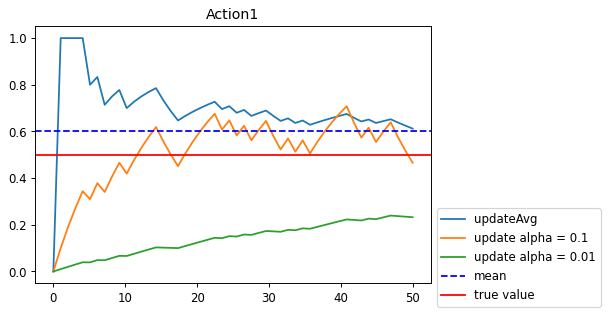

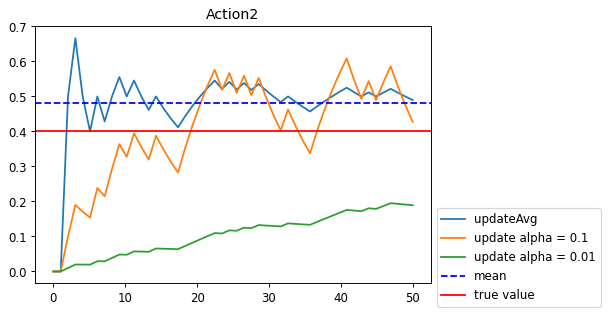

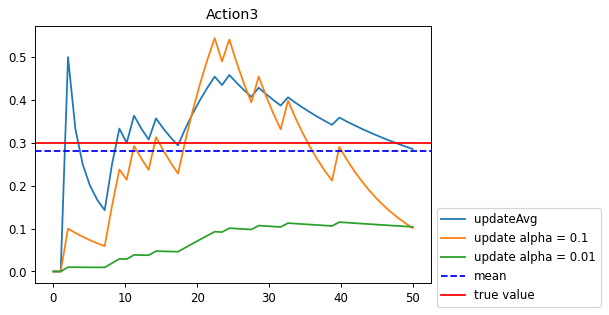

In [104]:
alphas = [0.1, 0.01]
sample_size = 50
x = np.linspace(0, sample_size, sample_size)
np.random.seed(0)
for i in range(len(q_star)):
  Q_avg, R_avg = run_bandit('UpdateByAverage', q_star, i, sample_size)
  plt.plot(x, Q_avg, '-', label="updateAvg")
  for idx, alpha in enumerate(alphas):
    Q_alpha, R_alpha  = run_bandit('UpdateByAlpha', q_star, i, sample_size, alpha)
    plt.plot(x, Q_alpha, '-', label="update alpha = " + str(alpha))
  plt.axhline(y = np.mean(R_alpha), linestyle='--',  label="mean", color = 'Blue')
  plt.axhline(y = q_star[i], linestyle='-',  label="true value", color = 'Red')
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.1))
  plt.title("Action" + str(i+1))
  plt.show()

# Q3

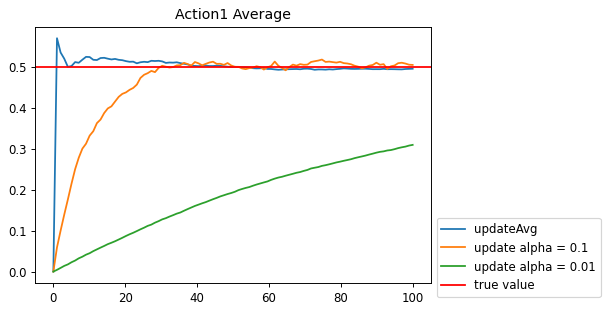

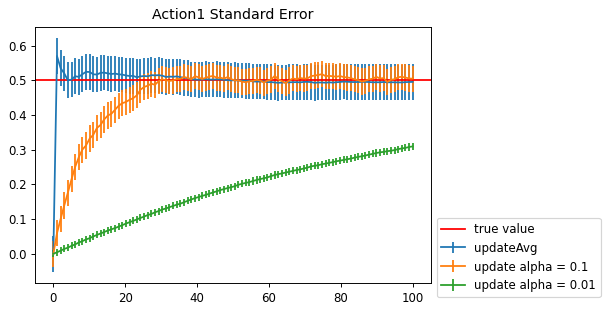

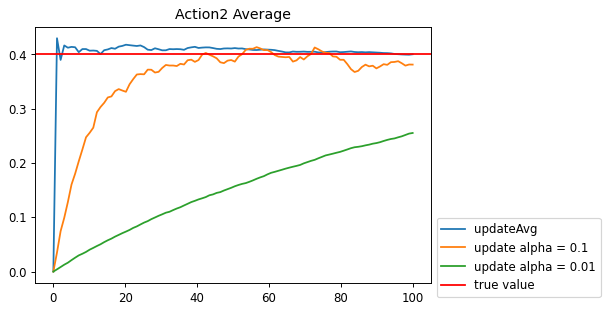

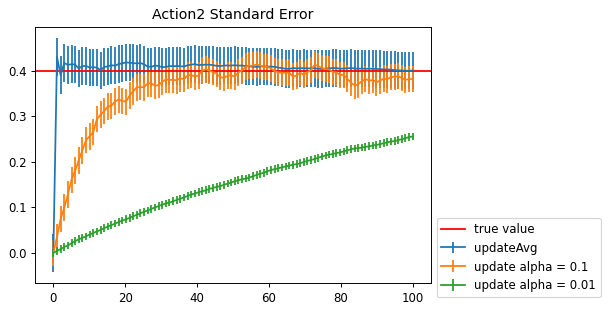

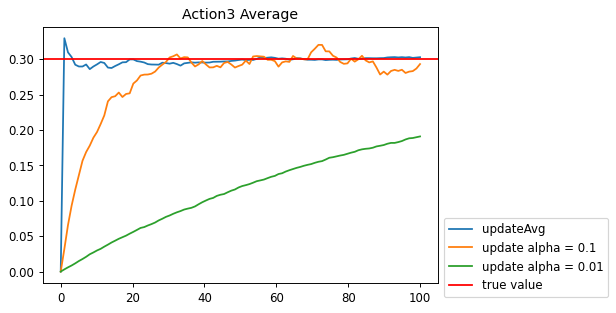

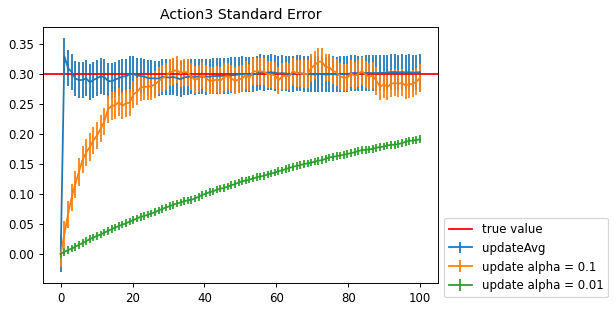

In [106]:
alphas = [0.1, 0.01]
sample_size = 100
runs = 100
x = np.linspace(0, sample_size, sample_size)
np.random.seed(0)

for i in range(len(q_star)):
  Q_1 = np.empty([100,100])
  Q_2 = np.empty([100,100])
  Q_3 = np.empty([100,100])
  for run in range(runs):
    ## average
    bandit = MAB(q_star)
    Q_avg = np.zeros(sample_size)
    R_avg = np.zeros(sample_size)
    step = 1
    R_avg[0] = bandit.sample(i)
    while step < sample_size:
        Q_avg = bandit.updateAvg(R_avg,Q_avg,step)
        R_avg[step] = bandit.sample(i)
        step += 1
    Q_1[run] = Q_avg

    ## alpha 0.1
    bandit = MAB(q_star)
    Q_alpha = np.zeros(sample_size)
    R_alpha = np.zeros(sample_size)
    step = 1
    R_alpha[0] = bandit.sample(i)
    while step < sample_size:
        Q_alpha = bandit.update(alphas[0],R_alpha,Q_alpha,step)
        R_alpha[step] = bandit.sample(i)
        step += 1
    Q_2[run] = Q_alpha

    ## alpha 0.01
    bandit = MAB(q_star)
    Q_alpha2 = np.zeros(sample_size)
    R_alpha2 = np.zeros(sample_size)
    step = 1
    R_alpha2[0] = bandit.sample(i)
    while step < sample_size:
        Q_alpha2 = bandit.update(alphas[1],R_alpha2,Q_alpha2,step)
        R_alpha2[step] = bandit.sample(i)
        step += 1
    Q_3[run] = Q_alpha2

  Q_1 = np.mean(Q_1,axis = 0)
  Q_2 = np.mean(Q_2,axis = 0)
  Q_3 = np.mean(Q_3,axis = 0)

  plt.plot(x, Q_1, '-', label="updateAvg")
  plt.plot(x, Q_2, '-', label="update alpha = " + str(alphas[0]))
  plt.plot(x, Q_3, '-', label="update alpha = " + str(alphas[1]))
  plt.axhline(y = q_star[i], linestyle='-', color='Red', label="true value")
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.1))
  plt.title("Action" + str(i+1) + ' Average')
  plt.show()

  std_0 = np.cumsum(Q_1,axis=0)
  std_1 = np.divide(std_0[1:],np.linspace(1, sample_size-1, sample_size-1))
  std_2 = np.mean(std_1)
  plt.errorbar(x,Q_1,yerr=std_2/math.sqrt(100),label="updateAvg")
  std_0 = np.cumsum(Q_2,axis=0)
  std_1 = np.divide(std_0[1:],np.linspace(1, sample_size-1, sample_size-1))
  std_2 = np.mean(std_1)
  plt.errorbar(x,Q_2,yerr=std_2/math.sqrt(100),label="update alpha = " + str(alphas[0]))
  std_0 = np.cumsum(Q_3,axis=0)
  std_1 = np.divide(std_0[1:],np.linspace(1, sample_size-1, sample_size-1))
  std_2 = np.mean(std_1)
  plt.errorbar(x,Q_3,yerr=std_2/math.sqrt(100), label="update alpha = " + str(alphas[1]))
  plt.axhline(y = q_star[i], linestyle='-', color='Red', label="true value")
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.1))
  plt.title("Action" + str(i+1) + " Standard Error")
  plt.show()
  

α = 0.1 is better since its converges faster than α = 0.01. Compared to averaging, the curve of α = 0.1 has more fluctuation while the curve of α = 0.01 converge slower but more stable. To optimize the result, we can look for α in the range of \[0.01, 0.05\] .

#Q4

## Average Rewards

In [8]:
def rewards_graph(epsilon,line_label):
  np.random.seed(0)
  total_rewards = np.empty([100,1000])
  for i in range(0,100):
    Q4 = MAB(p, run_steps = 1000)
    Rewards, Q, N, select_first, ins_regrets = Q4.e_greedy(epsilon)
    total_rewards[i] = Rewards
  average_rewards = np.mean(total_rewards, axis=0)
  cumu_rewards = np.cumsum(average_rewards)
  tot_rewards = np.divide(cumu_rewards, np.linspace(1,1000,1000))

  x = np.linspace(1, 1000, 1000)

  plt.plot(x, tot_rewards, '-', label=line_label)

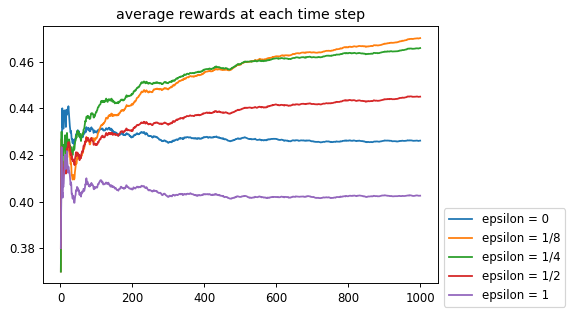

In [9]:
rewards_graph(0,"epsilon = 0")
rewards_graph(1/8,"epsilon = 1/8")
rewards_graph(1/4,"epsilon = 1/4")
rewards_graph(1/2,"epsilon = 1/2")
rewards_graph(1,"epsilon = 1")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.1))
plt.title("average rewards at each time step")
plt.show()

## Standard Error

In [10]:
def std_error(epsilon,line_label):
  np.random.seed(0)
  total_rewards = np.empty([100,1000])
  select = np.zeros(1000)
  for i in range(0,100):
    Q4 = MAB(p, run_steps = 1000)
    Rewards, Q, N, select_first, ins_regrets = Q4.e_greedy(epsilon)
    total_rewards[i] = Rewards
  x = np.linspace(1, 1000, 1000)
  average_rewards = np.mean(total_rewards, axis=0)
  cumu_rewards = np.cumsum(average_rewards)
  tot_rewards = np.divide(cumu_rewards, np.linspace(1,1000,1000))
  std_0 = np.cumsum(total_rewards,axis=0)
  std_1 = np.divide(std_0,x)
  std_2 = np.mean(std_1)

  plt.errorbar(x,tot_rewards,yerr=std_2/math.sqrt(1000),label=line_label)

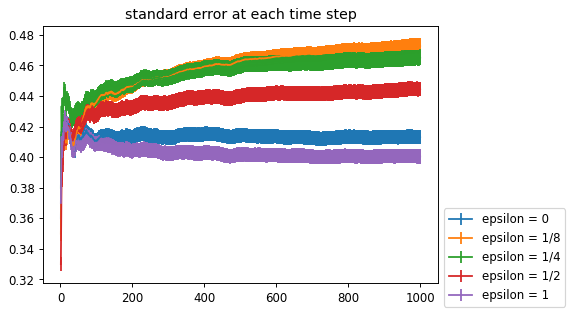

In [11]:
std_error(0,"epsilon = 0")
std_error(1/8,"epsilon = 1/8")
std_error(1/4,"epsilon = 1/4")
std_error(1/2,"epsilon = 1/2")
std_error(1,"epsilon = 1")


plt.legend(loc='center left', bbox_to_anchor=(1, 0.1))
plt.title("standard error at each time step")
plt.show()

## Best Action Fraction

In [12]:
def fraction(epsilon,line_label):
  np.random.seed(0)
  total_rewards = np.empty([100,1000])
  select = np.zeros(1000)
  for i in range(0,100):
    Q4 = MAB(p, run_steps = 1000)
    Rewards, Q, N, select_first, ins_regrets = Q4.e_greedy(epsilon)
    total_rewards[i] = Rewards
    select = np.add(select,select_first)
  x = np.linspace(1, 1000, 1000)
  fractions = select/100
  plt.plot(x,fractions,label=line_label)

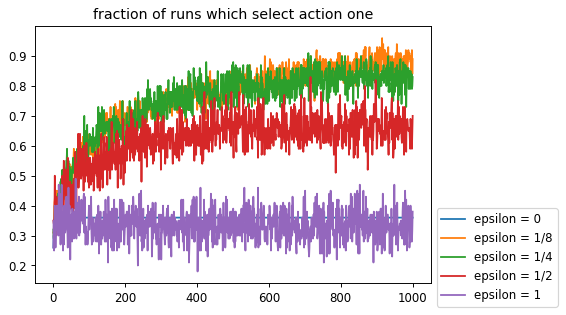

In [13]:
fraction(0,"epsilon = 0")
fraction(1/8,"epsilon = 1/8")
fraction(1/4,"epsilon = 1/4")
fraction(1/2,"epsilon = 1/2")
fraction(1,"epsilon = 1")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.1))
plt.title("fraction of runs which select action one")
plt.show()

## Instantaneous Regret

In [14]:
def ins_regret(epsilon,line_label):
  np.random.seed(0)
  total_rewards = np.empty([100,1000])
  ins_regrets = np.zeros(1000)
  for i in range(0,100):
    Q4 = MAB(p, run_steps = 1000)
    Rewards, Q, N, select_first, ins_regret = Q4.e_greedy(epsilon)
    total_rewards[i] = Rewards
    ins_regrets = np.add(ins_regrets,ins_regret)
  x = np.linspace(1, 1000, 1000)
  i_regrets = ins_regrets/100

  plt.plot(x,i_regrets,label=line_label)

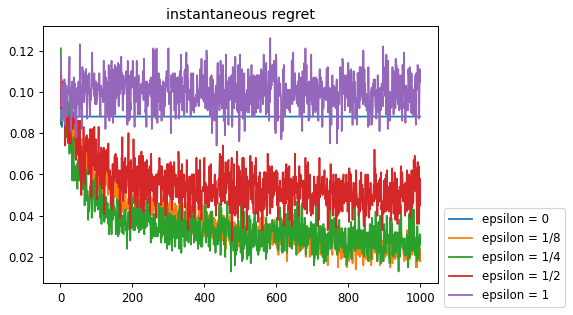

In [15]:
ins_regret(0,"epsilon = 0")
ins_regret(1/8,"epsilon = 1/8")
ins_regret(1/4,"epsilon = 1/4")
ins_regret(1/2,"epsilon = 1/2")
ins_regret(1,"epsilon = 1")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.1))
plt.title("instantaneous regret")
plt.show()

## Total Regret

In [16]:
def total_regret(epsilon,line_label):
  np.random.seed(0)
  total_rewards = np.empty([100,1000])
  ins_regrets = np.zeros(1000)
  for i in range(0,100):
    Q4 = MAB(p, run_steps = 1000)
    Rewards, Q, N, select_first, ins_regret = Q4.e_greedy(epsilon)
    total_rewards[i] = Rewards
    ins_regrets = np.add(ins_regrets,ins_regret)

  x = np.linspace(1, 1000, 1000)
  i_regrets = ins_regrets/100
  t_regrets = np.cumsum(i_regrets)
 
  plt.plot(x,t_regrets,label=line_label)

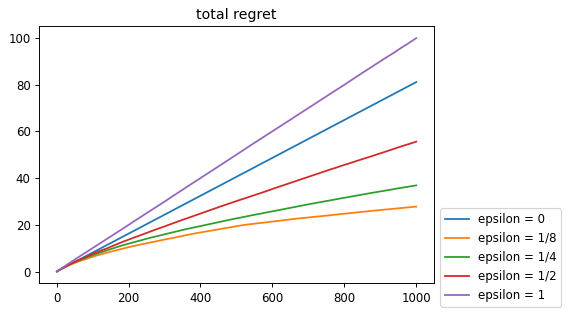

In [17]:
total_regret(0,"epsilon = 0")
total_regret(1/8,"epsilon = 1/8")
total_regret(1/4,"epsilon = 1/4")
total_regret(1/2,"epsilon = 1/2")
total_regret(1,"epsilon = 1")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.1))
plt.title("total regret")
plt.show()

When epsilon = 1/8, the model performs the best. Both the average rewards and the fraction of the best run are the highest. The instantaneous and total regrets are the lowest. We need to find a balance between exploration and exploitation. In this case, exploration with 1/8 probability seems to be the best.

#Q5

## Average Rewards

In [18]:
def rewards_epsilon_lr(epsilon,lr,line_label):
  np.random.seed(0)
  total_rewards = np.empty([100,1000])
  for i in range(0,100):
    Q5 = MAB(p, run_steps = 1000)
    Rewards, Q, N, select_first, ins_regrets = Q5.e_greedy_lr(epsilon,lr)
    total_rewards[i] = Rewards

  average_rewards = np.mean(total_rewards, axis=0)
  cumu_rewards = np.cumsum(average_rewards)
  tot_rewards = np.divide(cumu_rewards, np.linspace(1,1000,1000))

  x = np.linspace(1, 1000, 1000)

  plt.plot(x, tot_rewards, '-', label=line_label)

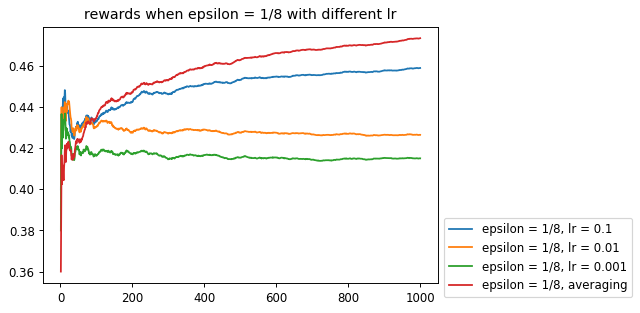

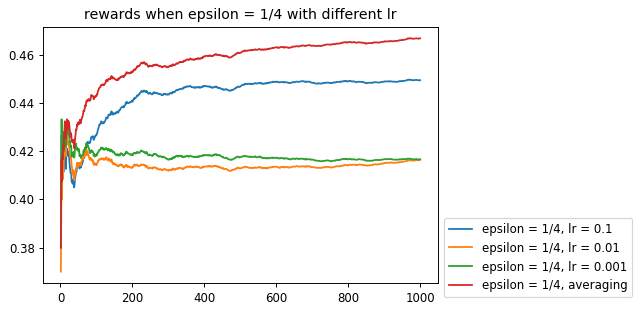

In [19]:
rewards_epsilon_lr(1/8,0.1,"epsilon = 1/8, lr = 0.1")
rewards_epsilon_lr(1/8,0.01,"epsilon = 1/8, lr = 0.01")
rewards_epsilon_lr(1/8,0.001,"epsilon = 1/8, lr = 0.001")
rewards_graph(1/8,"epsilon = 1/8, averaging")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.1))
plt.title("rewards when epsilon = 1/8 with different lr")
plt.show()

rewards_epsilon_lr(1/4,0.1,"epsilon = 1/4, lr = 0.1")
rewards_epsilon_lr(1/4,0.01,"epsilon = 1/4, lr = 0.01")
rewards_epsilon_lr(1/4,0.001,"epsilon = 1/4, lr = 0.001")
rewards_graph(1/4,"epsilon = 1/4, averaging")


plt.legend(loc='center left', bbox_to_anchor=(1, 0.1))
plt.title("rewards when epsilon = 1/4 with different lr")
plt.show()


## Standard Error

In [20]:
def std_error_lr(epsilon,lr,line_label):
  np.random.seed(0)
  total_rewards = np.empty([100,1000])
  select = np.zeros(1000)
  for i in range(0,100):
    Q5 = MAB(p, run_steps = 1000)
    Rewards, Q, N, select_first, ins_regrets = Q5.e_greedy_lr(epsilon,lr)
    total_rewards[i] = Rewards

  x = np.linspace(1, 1000, 1000)

  average_rewards = np.mean(total_rewards, axis=0)
  cumu_rewards = np.cumsum(average_rewards)
  tot_rewards = np.divide(cumu_rewards, np.linspace(1,1000,1000))

  std_0 = np.cumsum(total_rewards,axis=0)
  std_1 = np.divide(std_0,x)
  std_2 = np.mean(std_1)

  plt.errorbar(x,tot_rewards,yerr=std_2/math.sqrt(1000),label=line_label)

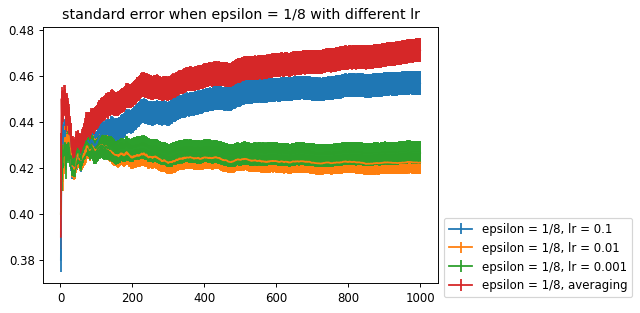

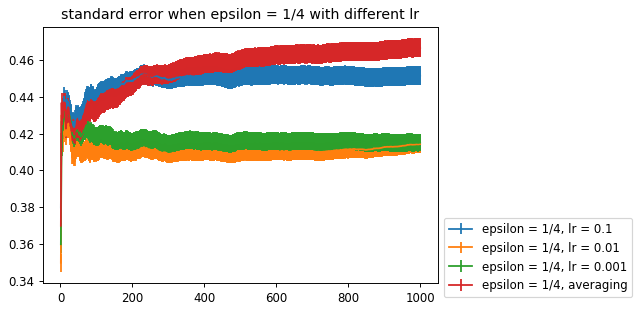

In [21]:
std_error_lr(1/8,0.1,"epsilon = 1/8, lr = 0.1")
std_error_lr(1/8,0.01,"epsilon = 1/8, lr = 0.01")
std_error_lr(1/8,0.001,"epsilon = 1/8, lr = 0.001")
std_error(1/8,"epsilon = 1/8, averaging")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.1))
plt.title("standard error when epsilon = 1/8 with different lr")
plt.show()

std_error_lr(1/4,0.1,"epsilon = 1/4, lr = 0.1")
std_error_lr(1/4,0.01,"epsilon = 1/4, lr = 0.01")
std_error_lr(1/4,0.001,"epsilon = 1/4, lr = 0.001")
std_error(1/4,"epsilon = 1/4, averaging")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.1))
plt.title("standard error when epsilon = 1/4 with different lr")
plt.show()


## Best Action Fraction

In [22]:
def fraction_lr(epsilon,lr,line_label):
  np.random.seed(0)
  total_rewards = np.empty([100,1000])
  select = np.zeros(1000)
  for i in range(0,100):
    Q5 = MAB(p, run_steps = 1000)
    Rewards, Q, N, select_first, ins_regrets = Q5.e_greedy_lr(epsilon,lr)
    total_rewards[i] = Rewards
    select = np.add(select,select_first)

  x = np.linspace(1, 1000, 1000)

  fractions = select/100

  plt.plot(x,fractions,'-',label=line_label)

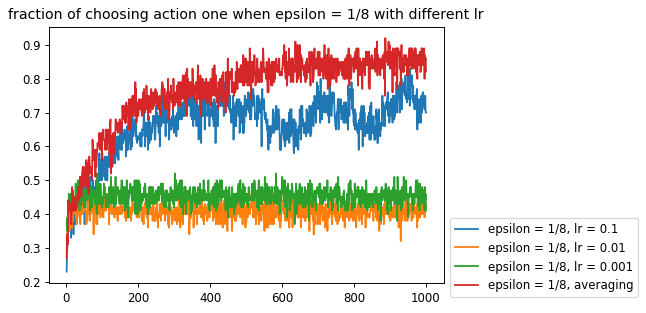

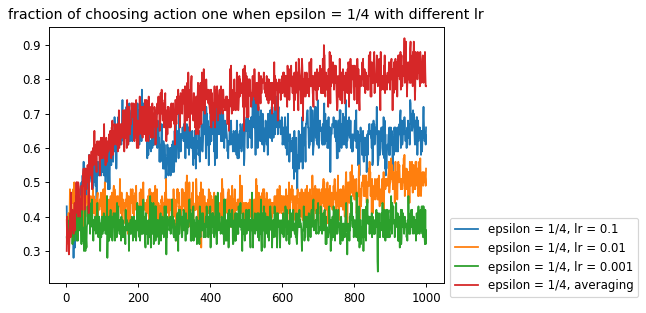

In [23]:
fraction_lr(1/8,0.1,"epsilon = 1/8, lr = 0.1")
fraction_lr(1/8,0.01,"epsilon = 1/8, lr = 0.01")
fraction_lr(1/8,0.001,"epsilon = 1/8, lr = 0.001")
fraction(1/8,"epsilon = 1/8, averaging")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.1))
plt.title("fraction of choosing action one when epsilon = 1/8 with different lr")
plt.show()

fraction_lr(1/4,0.1,"epsilon = 1/4, lr = 0.1")
fraction_lr(1/4,0.01,"epsilon = 1/4, lr = 0.01")
fraction_lr(1/4,0.001,"epsilon = 1/4, lr = 0.001")
fraction(1/4,"epsilon = 1/4, averaging")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.1))
plt.title("fraction of choosing action one when epsilon = 1/4 with different lr")
plt.show()

## Instantaneous Regret

In [24]:
def ins_regret_lr(epsilon,lr,line_label):
  np.random.seed(0)
  total_rewards = np.empty([100,1000])
  ins_regrets = np.zeros(1000)
  for i in range(0,100):
    Q5 = MAB(p, run_steps = 1000)
    Rewards, Q, N, select_first, ins_regret = Q5.e_greedy_lr(epsilon,lr)
    total_rewards[i] = Rewards
    ins_regrets = np.add(ins_regrets,ins_regret)

  x = np.linspace(1, 1000, 1000)
  i_regrets = ins_regrets/100

  plt.plot(x,i_regrets,label=line_label)

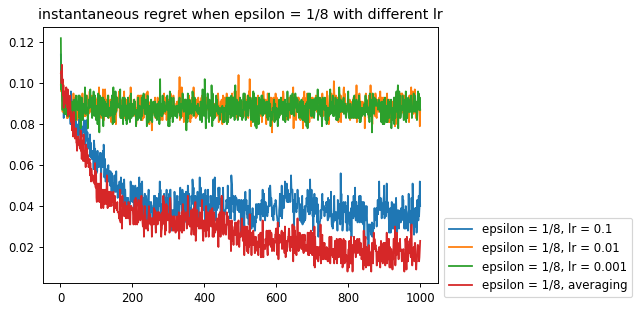

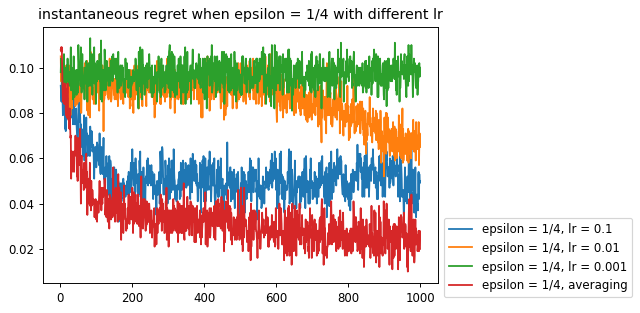

In [25]:
ins_regret_lr(1/8,0.1,"epsilon = 1/8, lr = 0.1")
ins_regret_lr(1/8,0.01,"epsilon = 1/8, lr = 0.01")
ins_regret_lr(1/8,0.001,"epsilon = 1/8, lr = 0.001")
ins_regret(1/8,"epsilon = 1/8, averaging")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.1))
plt.title("instantaneous regret when epsilon = 1/8 with different lr")
plt.show()

ins_regret_lr(1/4,0.1,"epsilon = 1/4, lr = 0.1")
ins_regret_lr(1/4,0.01,"epsilon = 1/4, lr = 0.01")
ins_regret_lr(1/4,0.001,"epsilon = 1/4, lr = 0.001")
ins_regret(1/4,"epsilon = 1/4, averaging")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.1))
plt.title("instantaneous regret when epsilon = 1/4 with different lr")
plt.show()

## Total Regret

In [26]:
def total_regret_lr(epsilon,lr,line_label):
  np.random.seed(0)
  total_rewards = np.empty([100,1000])
  ins_regrets = np.zeros(1000)
  for i in range(0,100):
    Q5 = MAB(p, run_steps = 1000)
    Rewards, Q, N, select_first, ins_regret = Q5.e_greedy_lr(epsilon,lr)
    total_rewards[i] = Rewards
    ins_regrets = np.add(ins_regrets,ins_regret)

  x = np.linspace(1, 1000, 1000)
  i_regrets = ins_regrets/100
  t_regrets = np.cumsum(i_regrets)
 
  plt.plot(x,t_regrets,label=line_label)

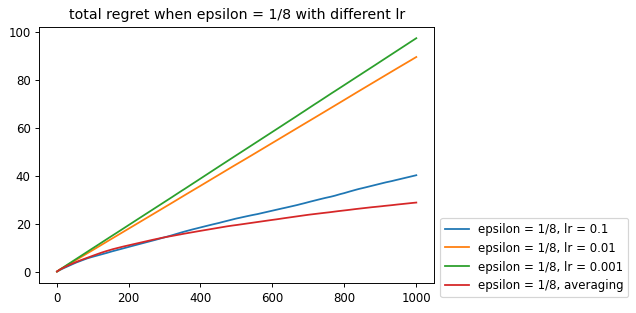

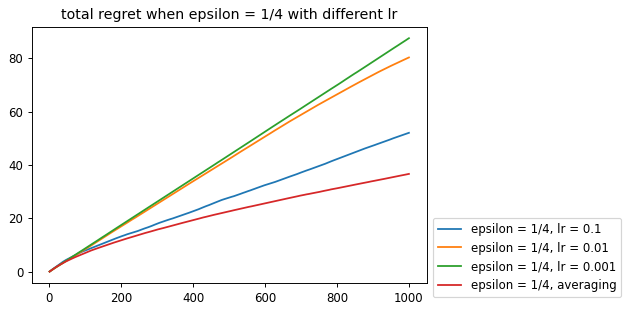

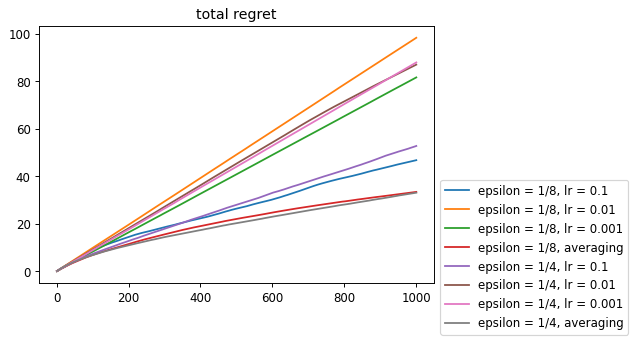

In [27]:
total_regret_lr(1/8,0.1,"epsilon = 1/8, lr = 0.1")
total_regret_lr(1/8,0.01,"epsilon = 1/8, lr = 0.01")
total_regret_lr(1/8,0.001,"epsilon = 1/8, lr = 0.001")
total_regret(1/8,"epsilon = 1/8, averaging")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.1))
plt.title("total regret when epsilon = 1/8 with different lr")
plt.show()

total_regret_lr(1/4,0.1,"epsilon = 1/4, lr = 0.1")
total_regret_lr(1/4,0.01,"epsilon = 1/4, lr = 0.01")
total_regret_lr(1/4,0.001,"epsilon = 1/4, lr = 0.001")
total_regret(1/4,"epsilon = 1/4, averaging")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.1))
plt.title("total regret when epsilon = 1/4 with different lr")
plt.show()

total_regret_lr(1/8,0.1,"epsilon = 1/8, lr = 0.1")
total_regret_lr(1/8,0.01,"epsilon = 1/8, lr = 0.01")
total_regret_lr(1/8,0.001,"epsilon = 1/8, lr = 0.001")
total_regret(1/8,"epsilon = 1/8, averaging")
total_regret_lr(1/4,0.1,"epsilon = 1/4, lr = 0.1")
total_regret_lr(1/4,0.01,"epsilon = 1/4, lr = 0.01")
total_regret_lr(1/4,0.001,"epsilon = 1/4, lr = 0.001")
total_regret(1/4,"epsilon = 1/4, averaging")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.1))
plt.title("total regret")
plt.show()

The model performs the best when epsilon = 1/8 and using averaging approach. The regrets are the least and the fracton of choosing best action is the highest.

#Q6

In [28]:
def run_ucb(runs, time_step, c, alpha = None):
  np.random.seed(0)
  rewards = np.zeros((runs, time_step))
  regret = np.zeros((runs, time_step))
  selection_rec = np.zeros((runs, time_step))
  for r in range(runs):
      UCB = MAB(q_star, c=2)
      
      R = [[],[],[]]
      Q = [[0],[0],[0]]
      for t in range(time_step):
          R, Q, reward,selected_arm, inst_regret = UCB.ucb(R, Q,alpha)
          rewards[r, t] = reward + rewards[r, t-1]
          regret[r, t] = inst_regret
          if selected_arm == 0: 
             selection_rec[r,t] = 1
  average_rewards = np.mean(rewards, axis=0)
  selection_tot = np.sum(selection_rec,axis = 0)
  selection_frac = np.divide(selection_tot, runs)
  average_regret = np.mean(regret, axis=0)
  tot_regret = np.cumsum(regret,axis = 1)
  tot_regret = np.mean(tot_regret, axis=0)
  return average_rewards,selection_frac, average_regret, tot_regret

In [29]:
def ucb_std_error(total_rewards,time_step, alpha = None, idx = None):
    x = np.linspace(1, time_step, time_step)
    if alpha != None:
      std_0 = np.cumsum(total_rewards,axis=0)
      std_1 = np.divide(std_0,x)
      std_2 = np.mean(std_1)
      plt.errorbar(x,tot_rewards,yerr=std_2/math.sqrt(1000),label="alpha = " + str(alpha))
    else:
      std_0 = np.cumsum(total_rewards,axis=0)
      std_1 = np.divide(std_0,x)
      std_2 = np.mean(std_1)
      plt.errorbar(x,tot_rewards,yerr=std_2/math.sqrt(1000),label="Averaging")

In [30]:
time_step = 1000
runs = 100
c = 2
alphas = [0.1, 0.01, 0.001]
x = np.linspace(0, time_step, time_step)

## Average Rewards

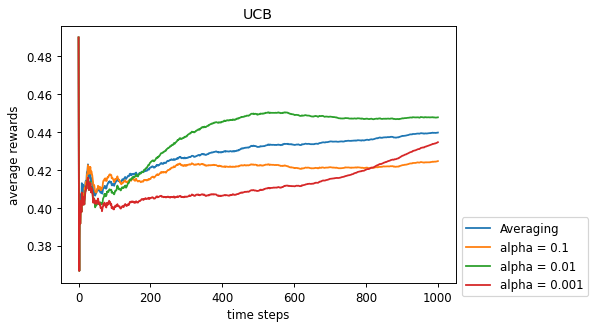

In [31]:
average_rewards, select_frac, average_regret, tot_regret = run_ucb(runs, time_step, c)
tot_rewards = np.divide(average_rewards, np.linspace(1,time_step,time_step))
plt.plot(x, tot_rewards, '-', label="Averaging")
for idx, alpha in enumerate(alphas):
    average_rewards, select_frac, average_regret, tot_regret = run_ucb(runs, time_step, c, alpha)
    tot_rewards = np.divide(average_rewards, np.linspace(1,time_step,time_step))
    plt.plot(x, tot_rewards, '-', label="alpha = " + str(alpha))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.1))
plt.xlabel('time steps')
plt.ylabel('average rewards')
plt.title("UCB")
plt.show()

## Standard Error

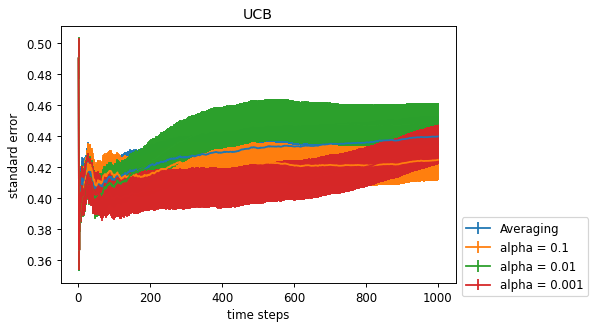

In [32]:
average_rewards, select_frac, average_regret, tot_regret = run_ucb(runs, time_step, c)
tot_rewards = np.divide(average_rewards, np.linspace(1,time_step,time_step))
ucb_std_error(tot_rewards,time_step)
for idx, alpha in enumerate(alphas):
    average_rewards, select_frac, average_regret, tot_regret = run_ucb(runs, time_step, c, alpha)
    tot_rewards = np.divide(average_rewards, np.linspace(1,time_step,time_step))
    ucb_std_error(tot_rewards,time_step,alpha,idx)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.1))
plt.xlabel('time steps')
plt.ylabel('standard error')
plt.title("UCB")
plt.show()

## Best Action Fraction

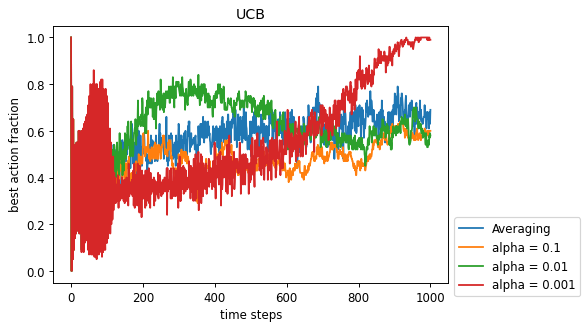

In [33]:
x = np.linspace(0, time_step, time_step)
average_rewards, select_frac, average_regret, tot_regret = run_ucb(runs, time_step, c)
plt.plot(x, select_frac, '-', label="Averaging")
for idx, alpha in enumerate(alphas):
    average_rewards, select_frac, average_regret, tot_regret = run_ucb(runs, time_step, c, alpha)
    plt.plot(x, select_frac, '-', label="alpha = " + str(alpha))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.1))
plt.xlabel('time steps')
plt.ylabel('best action fraction')
plt.title("UCB")
plt.show()

## Instantaneous Regret

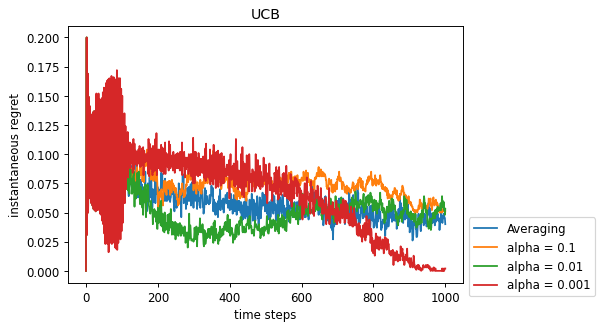

In [34]:
average_rewards, select_frac, average_regret, tot_regret  = run_ucb(runs, time_step, c)
plt.plot(x, average_regret, '-', label="Averaging")
for idx, alpha in enumerate(alphas):
    average_rewards, select_frac, average_regret, tot_regret  = run_ucb(runs, time_step, c, alpha)
    plt.plot(x, average_regret, '-', label="alpha = " + str(alpha))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.1))
plt.xlabel('time steps')
plt.ylabel('instantaneous regret')
plt.title("UCB")
plt.show()

## Total Regret

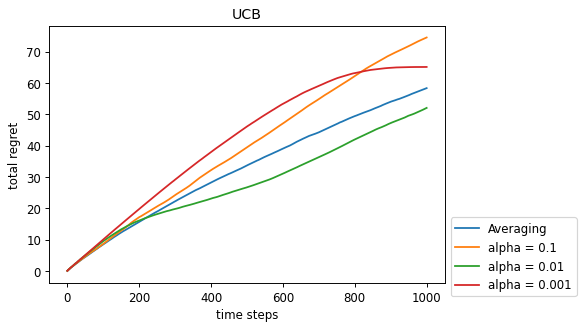

In [35]:
average_rewards, select_frac, average_regret, tot_regret  = run_ucb(runs, time_step, c)
plt.plot(x, tot_regret, '-', label="Averaging")
for idx, alpha in enumerate(alphas):
    average_rewards, select_frac, average_regret, tot_regret  = run_ucb(runs, time_step, c, alpha)
    plt.plot(x, tot_regret, '-', label="alpha = " + str(alpha))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.1))
plt.xlabel('time steps')
plt.ylabel('total regret')
plt.title("UCB")
plt.show()

We found that when α = 0.001, the best action fraction will converge to 1 at around 900-time steps while the instantaneous reward of it decreases to 0. When α = 0.01 and α = 0.1, the results are similar, both best action fractions converge to 0.6, but the average rewards of α = 0.01 is the highest. The averaging approach has a comparably poor performance since it has high regrets and low awards.

# Q7

In [36]:
def run_thomplinson(runs, time_step):
  np.random.seed(0)
  rewards = np.zeros((runs, time_step))
  regret = np.zeros((runs, time_step))
  selection_rec = np.zeros((runs, time_step))
  for r in range(runs):
    bandit = MAB(q_star)
    for t in range(time_step):
      reward, selected_arm, inst_regret = bandit.ThomplinsonSampling()
      regret[r, t] = inst_regret
      rewards[r, t] = reward + rewards[r, t-1]
      if selected_arm == 0: 
            selection_rec[r,t] = 1
  average_rewards = np.mean(rewards, axis=0)
  selection_tot = np.sum(selection_rec,axis = 0)
  selection_frac = np.divide(selection_tot, runs)
  average_regret = np.mean(regret, axis=0)
  tot_regret = np.cumsum(regret,axis = 1)
  tot_regret = np.mean(tot_regret, axis=0)
  return average_rewards,selection_frac, average_regret, tot_regret

In [37]:
def thom_std_error(total_rewards,time_step):
    x = np.linspace(1, time_step, time_step)
    std_0 = np.cumsum(total_rewards,axis=0)
    std_1 = np.divide(std_0,x)
    std_2 = np.mean(std_1)
    plt.errorbar(x,tot_rewards,yerr=std_2/math.sqrt(1000),label="Averaging")

## Average Rewards

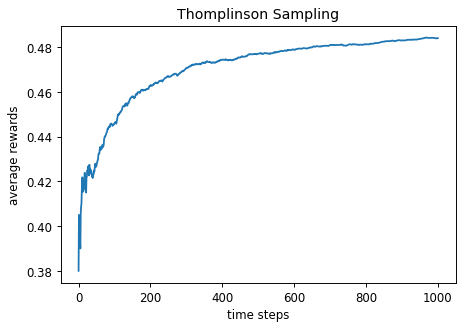

In [38]:
average_rewards, selection_frac,average_regret, tot_regret = run_thomplinson(runs,time_step)
tot_rewards = np.divide(average_rewards, np.linspace(1,time_step,time_step))
plt.plot(x, tot_rewards, '-')
plt.xlabel('time steps')
plt.ylabel('average rewards')
plt.title("Thomplinson Sampling")
plt.show()

## Standard Error

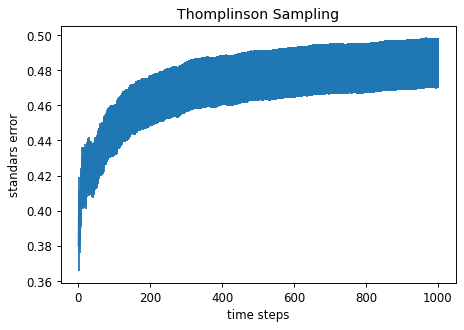

In [39]:
thom_std_error(tot_rewards, time_step)
plt.xlabel('time steps')
plt.ylabel('standars error')
plt.title("Thomplinson Sampling")
plt.show()

## Best Action Fraction

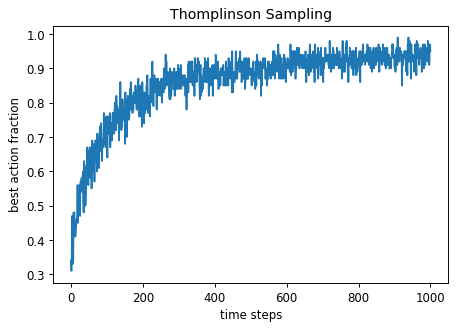

In [40]:
plt.plot(x, selection_frac, '-')
plt.xlabel('time steps')
plt.ylabel('best action fraction')
plt.title("Thomplinson Sampling")
plt.show()

## Instantaneous Regret

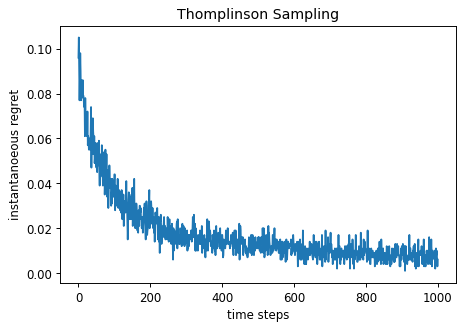

In [41]:
plt.plot(x, average_regret, '-')
plt.xlabel('time steps')
plt.ylabel('instantanoeous regret')
plt.title("Thomplinson Sampling")
plt.show()

## Total Regrets

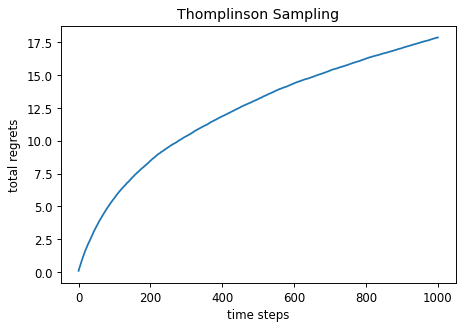

In [42]:
plt.plot(x, tot_regret, '-')
plt.xlabel('time steps')
plt.ylabel('total regrets')
plt.title("Thomplinson Sampling")
plt.show()

The performance of Tomlinson Sampling is very stable, and the instantaneous regret decreases smoothly to zero while the best action score increases to 1 within 1000 time steps. And the average awards also approach to 0.5 after 1000 timw steps.

#Q8

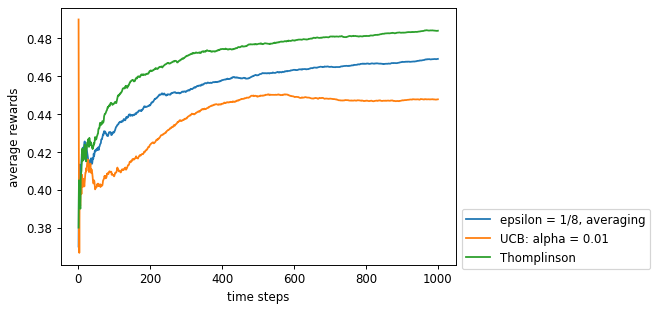

In [43]:
time_step =1000
x = np.linspace(1, time_step, time_step)
##epsilon greedy
rewards_graph(1/8,"epsilon = 1/8, averaging")
##ucb 
alpha = 0.01
average_rewards_ucb, select_frac_ucb,average_regret_ucb, tot_regret_ucb = run_ucb(runs, time_step, c, alpha)
tot_rewards_ucb = np.divide(average_rewards_ucb, np.linspace(1,time_step,time_step))
plt.plot(x, tot_rewards_ucb, '-', label="UCB: alpha = " + str(alpha))
##thomplinson
average_rewards_thom, selection_frac_thom, average_regret_thom, tot_regret_thom = run_thomplinson(runs,time_step)
tot_rewards_thom = np.divide(average_rewards_thom, np.linspace(1,time_step,time_step))
plt.plot(x, tot_rewards_thom, '-', label="Thomplinson")
plt.xlabel('time steps')
plt.ylabel('average rewards')
plt.title("")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.1))
plt.show()

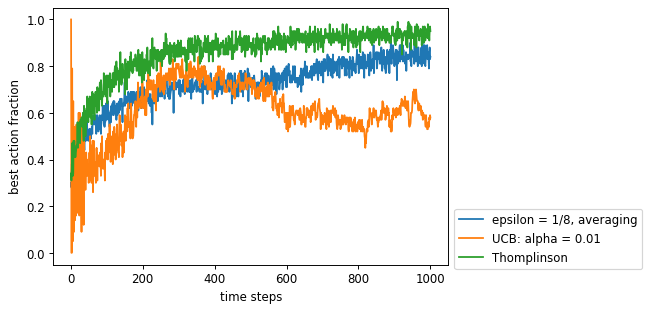

In [44]:
##epsilon-greedy
fraction(1/8,"epsilon = 1/8, averaging")
##ucb 
alpha = 0.01
average_rewards_ucb, select_frac_ucb,average_regret_ucb, tot_regret_ucb = run_ucb(runs, time_step, c, alpha)
plt.plot(x, select_frac_ucb, '-', label="UCB: alpha = " + str(alpha))
##thomplinson
average_rewards_thom, select_frac_thom, average_regret_thom, tot_regret_thom = run_thomplinson(runs,time_step)
plt.plot(x, select_frac_thom, '-', label="Thomplinson")
plt.xlabel('time steps')
plt.ylabel('best action fraction')
# plt.title("")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.1))
plt.show()

We chose ϵ = 1/8 with averaging approach for ϵ-greedy since we observed in Q5, it has lowest total regrets and highest average rewards. And α = 0.001 is chose for UCB for the same reason.
Thompson performs the best, achieving a nearly 100% best action fraction with the highest converging rate. e greedy also performs excellent, converges a little slower than Thompson, and reaches a 0.9 fraction. UCB performs great for the first 350 time steps but gets worse for the rest. 


#Q9

In [45]:
p = q_star
p_2 = [0.5,0.5+lamda,0.5+2*lamda]

In [46]:
p_2

[0.5, 0.6, 0.7]

## ϵ greedy nonstationary

In [47]:
run_steps = 1000

In [48]:
def rewards_q9(epsilon,lr,line_label):
  np.random.seed(0)
  total_rewards = np.empty([100,run_steps])
  for i in range(0,100):
    Q9 = MAB(p, run_steps)
    Rewards, Q, N = Q9.e_greedy_q9(epsilon,p_2,0.1)
    total_rewards[i] = Rewards
  average_rewards = np.mean(total_rewards, axis=0)
  cumu_rewards = np.cumsum(average_rewards)
  tot_rewards = np.divide(cumu_rewards, np.linspace(1,run_steps,run_steps))
  x = np.linspace(1, run_steps, run_steps)
  plt.plot(x, tot_rewards, '-', label=line_label)

In [49]:
def rewards_q9_avg(epsilon,line_label):
  np.random.seed(0)
  total_rewards = np.empty([100,run_steps])
  for i in range(0,100):
    Q9 = MAB(p, run_steps)
    Rewards, Q, N = Q9.e_greedy_q9(epsilon,p_2)
    total_rewards[i] = Rewards
  average_rewards = np.mean(total_rewards, axis=0)
  cumu_rewards = np.cumsum(average_rewards)
  tot_rewards = np.divide(cumu_rewards, np.linspace(1,run_steps,run_steps))
  x = np.linspace(1, run_steps, run_steps)
  plt.plot(x, tot_rewards, '-', label=line_label)

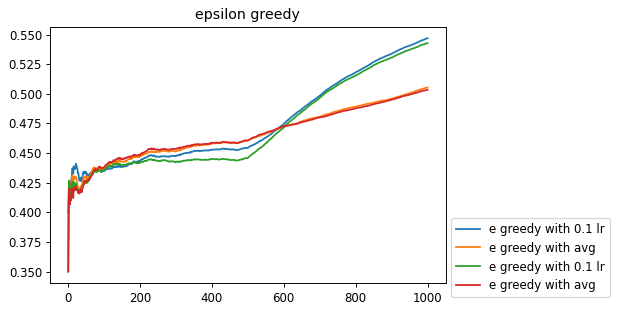

In [50]:
rewards_q9(1/8,0.1, "e greedy with 0.1 lr")
rewards_q9_avg(1/8,"e greedy with avg")
rewards_q9(1/4,0.1, "e greedy with 0.1 lr")
rewards_q9_avg(1/4,"e greedy with avg")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.1))
plt.title("epsilon greedy")
plt.show()

## ucb nonstationary



In [51]:
time_step = 1000
runs = 100
c = 2
alphas = [0.1]
x = np.linspace(0, time_step, time_step)

In [52]:
def ucb_nonstationary(runs, time_step, c, alpha = None):
  np.random.seed(0)
  rewards = np.zeros((runs, time_step))
  for r in range(runs):
    UCB = MAB(q_star, c=2)
    R = [[],[],[]]
    Q = [[0],[0],[0]]
    for t in range(500):
      R, Q, reward,selected_arm, inst_regret = UCB.ucb(R, Q,alpha)
      rewards[r, t] = reward + rewards[r, t-1]
    UCB.bandit_probs = p_2
    for t in range(500,time_step):
      R, Q, reward,selected_arm, inst_regret = UCB.ucb(R, Q,alpha)
      rewards[r, t] = reward + rewards[r, t-1]
  average_rewards = np.mean(rewards, axis=0)
  return average_rewards

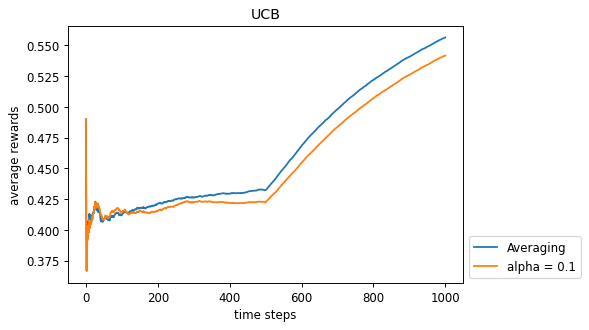

In [53]:
average_rewards= ucb_nonstationary(runs, time_step, c)
tot_rewards = np.divide(average_rewards, np.linspace(1,time_step,time_step))
plt.plot(x, tot_rewards, '-', label="Averaging")
for idx, alpha in enumerate(alphas):
    average_rewards= ucb_nonstationary(runs, time_step, c, alpha)
    tot_rewards = np.divide(average_rewards, np.linspace(1,time_step,time_step))
    plt.plot(x, tot_rewards, '-', label="alpha = " + str(alpha))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.1))
plt.xlabel('time steps')
plt.ylabel('average rewards')
plt.title("UCB")
plt.show()

## thomplinson nonstationary

In [54]:
def thomplinson_nonstationary(runs, time_step):
  np.random.seed(0)
  rewards = np.zeros((runs, time_step))
  for r in range(runs):
    bandit = MAB(q_star)
    for t in range(500):
      reward, selected_arm, inst_regret = bandit.ThomplinsonSampling()
      rewards[r, t] = reward + rewards[r, t-1]
    bandit.bandit_probs = p_2
    for t in range(500,time_step):
      reward, selected_arm, inst_regret = bandit.ThomplinsonSampling()
      rewards[r, t] = reward + rewards[r, t-1]
  average_rewards = np.mean(rewards, axis=0)
  return average_rewards

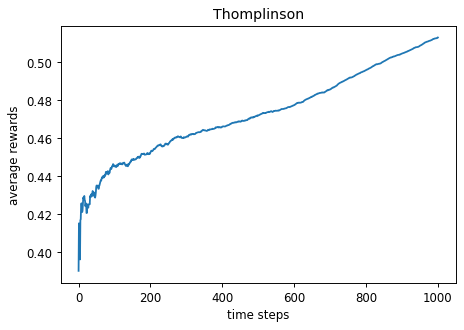

In [55]:
average_rewards_thom = thomplinson_nonstationary(runs,time_step)
tot_rewards_thom = np.divide(average_rewards_thom, np.linspace(1,time_step,time_step))
plt.plot(x, tot_rewards_thom, '-', label="Thomplinson")
plt.xlabel('time steps')
plt.ylabel('average rewards')
plt.title("Thomplinson")
plt.show()

## Summary

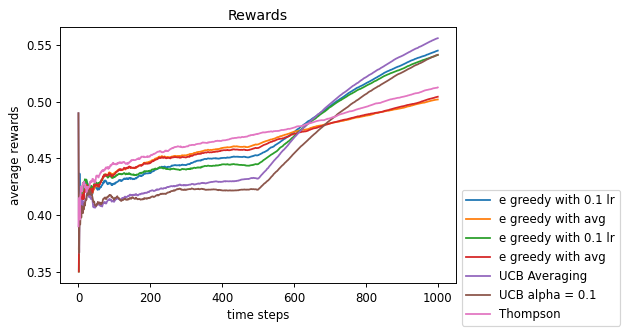

In [56]:
rewards_q9(1/8,0.1, "e greedy with 0.1 lr")
rewards_q9_avg(1/8,"e greedy with avg")
rewards_q9(1/4,0.1, "e greedy with 0.1 lr")
rewards_q9_avg(1/4,"e greedy with avg")

average_rewards= ucb_nonstationary(runs, time_step, c)
tot_rewards = np.divide(average_rewards, np.linspace(1,time_step,time_step))
plt.plot(x, tot_rewards, '-', label="UCB Averaging")
for idx, alpha in enumerate(alphas):
    average_rewards= ucb_nonstationary(runs, time_step, c, alpha)
    tot_rewards = np.divide(average_rewards, np.linspace(1,time_step,time_step))
    plt.plot(x, tot_rewards, '-', label="UCB alpha = " + str(alpha))
    
average_rewards_thom = thomplinson_nonstationary(runs,time_step)
tot_rewards_thom = np.divide(average_rewards_thom, np.linspace(1,time_step,time_step))
plt.plot(x, tot_rewards_thom, '-', label="Thompson")

plt.xlabel('time steps')
plt.ylabel('average rewards')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.1))
plt.title("Rewards")
plt.show()

We found that the UCB with averaging approach performs best among all algorithms with the highest average rewards. And the non-stationary significantly improved performance of algorithms not using the averaging approach.